In [21]:
%load_ext autoreload
%autoreload 2

import os
import warnings

from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, HTML, Javascript
from tqdm import tqdm


def alert(message='Loop completed!'):
    # Check if the system supports 'say' and notifications
    os.system(f'osascript -e \'display notification "{message}" with title "Notification"\'')
    # Speak the alert
    os.system(f'say "{message}"')        
        
os.environ['PYTHONBREAKPOINT'] = 'IPython.core.debugger.set_trace'
breakpoint = set_trace
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import textstat
from sklearn.preprocessing import MinMaxScaler

In [53]:
measures_df = pd.read_csv('data/archive/measures_20250305.csv')
ballot_data_df = pd.read_csv('data/archive/data_20241119.csv')
state_measures_df = pd.read_csv('data/archive/state_measures_20250412.csv')
precinct_df = pd.read_csv('data/archive/precincts-with-results.csv')

state_measures_df['level'] = 'state-level'
state_measures_df['measure_name'] = state_measures_df.title + ':'
state_measures_df['no_vote'] = state_measures_df.no_vote_meaning
state_measures_df['yes_vote'] = state_measures_df.yes_vote_meaning

measures_df = pd.concat([measures_df, state_measures_df], ignore_index=True)

# Create mapping of measure titles to ballot text
measure_text_map = dict(zip(measures_df.title, measures_df.ballot_text))

Now let's extract the ballot content and compute initial readability scores:

In [54]:
# Extract ballot content from full markdown
ballot_data_df['ballot_text'] = ballot_data_df.full_markdown.apply(lambda x: x.partition('\n---\n')[-1])

# Calculate initial readability scores
ballot_data_df['dale_chall_initial'] = ballot_data_df.ballot_text.progress_apply(textstat.dale_chall_readability_score_v2)
ballot_data_df['flesch_kincaid_initial'] = ballot_data_df.ballot_text.progress_apply(textstat.flesch_kincaid_grade)

# Calculate percentile rankings for readability scores
ballot_data_df['flesch_kincaid_percentile_initial'] = ballot_data_df.flesch_kincaid_initial.rank(pct=True)
ballot_data_df['dale_chall_percentile_initial'] = ballot_data_df.dale_chall_initial.rank(pct=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 50579/50579 [00:11<00:00, 4356.37it/s]


Extract measure titles from markdown:

In [55]:
def extract_ballot_measures(markdown_text):
    """Extract ballot measure titles from markdown text."""
    measures = []
    for section in markdown_text.split('---'):
        if '**Type:** Ballot Measure' in section:
            measure_title = section.split('## ')[1].split('\n')[0]
            measures.append(measure_title)
    return measures

# Extract measure titles from markdown
ballot_data_df['measure_titles'] = ballot_data_df.full_markdown.apply(extract_ballot_measures)

# Extract measure texts for each ballot
ballot_data_df['measure_texts'] = ballot_data_df.measure_titles.apply(
    lambda titles: [measure_text_map.get(title) for title in titles if title in measure_text_map]
)

Create enhanced ballots with measure texts and compute updated readability scores:

In [56]:
def create_enhanced_ballot(row):
    """Create enhanced ballot by inserting measure texts."""
    enhanced_text = row.ballot_text
    for measure_title in row.measure_titles:
        if measure_title in measure_text_map:
            enhanced_text = enhanced_text.replace(
                measure_title, 
                f'{measure_title}\n\n{measure_text_map[measure_title]}'
            )
    return enhanced_text

# Create enhanced ballots
ballot_data_df['enhanced_ballot'] = ballot_data_df.apply(create_enhanced_ballot, axis=1)

# Calculate updated readability scores
ballot_data_df['dale_chall_enhanced'] = ballot_data_df.enhanced_ballot.progress_apply(textstat.dale_chall_readability_score_v2)
ballot_data_df['flesch_kincaid_enhanced'] = ballot_data_df.enhanced_ballot.progress_apply(textstat.flesch_kincaid_grade)

# Calculate percentile rankings for updated scores
ballot_data_df['flesch_kincaid_percentile_enhanced'] = ballot_data_df.flesch_kincaid_enhanced.rank(pct=True)
ballot_data_df['dale_chall_percentile_enhanced'] = ballot_data_df.dale_chall_enhanced.rank(pct=True)

# Calculate changes in complexity
ballot_data_df['dale_chall_flesch_diff'] = ballot_data_df.dale_chall_percentile_enhanced - ballot_data_df.flesch_kincaid_percentile_enhanced
ballot_data_df['flesch_kincaid_change'] = ballot_data_df.flesch_kincaid_percentile_enhanced - ballot_data_df.flesch_kincaid_percentile_initial
ballot_data_df['dale_chall_change'] = ballot_data_df.dale_chall_percentile_enhanced - ballot_data_df.dale_chall_percentile_initial

100%|██████████████████████████████████████████████████████████████████████████████████| 50579/50579 [00:14<00:00, 3526.47it/s]


Analyze differences in text complexity:

In [57]:
import difflib

def generate_text_diff(text1, text2, context_lines=2):
    """Generate a unified diff between two texts."""
    diff = difflib.unified_diff(
        text1.splitlines(), text2.splitlines(), lineterm='', n=context_lines
    )
    return '\n'.join(diff)

# Function to display complexity changes
def display_complexity_changes(sorted_df, metric_name, n=5):
    """Display ballots with largest increases and decreases in complexity."""
    print(f'===== {metric_name.replace("_", " ").title()} =====')
    
    print('\nBIGGEST INCREASES IN COMPLEXITY:')
    increases = sorted_df.head(n)
    print(increases.drop(columns=['ballot_text', 'enhanced_ballot']).head())
    
    for i, row in increases.head(3).iterrows():
        print('\n------- Text Diff -------')
        diff = generate_text_diff(row.ballot_text, row.enhanced_ballot)
        print(diff)
    
    print('\nBIGGEST DECREASES IN COMPLEXITY:')
    decreases = sorted_df.tail(n)
    print(decreases.drop(columns=['ballot_text', 'enhanced_ballot']).tail())
    
    for i, row in decreases.tail(3).iterrows():
        print('\n------- Text Diff -------')
        diff = generate_text_diff(row.ballot_text, row.enhanced_ballot)
        print(diff)

# Create sorted dataframes
dale_chall_diff_df = ballot_data_df.sort_values(by='dale_chall_flesch_diff')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'dale_chall_flesch_diff', 'dale_chall_percentile_enhanced', 'flesch_kincaid_percentile_enhanced']
]

flesch_kincaid_change_df = ballot_data_df.sort_values(by='flesch_kincaid_change')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'flesch_kincaid_change', 'flesch_kincaid_percentile_initial', 'flesch_kincaid_percentile_enhanced']
]

dale_chall_change_df = ballot_data_df.sort_values(by='dale_chall_change')[
    ['state', 'district', 'county', 'zip', 'ballot_text', 'enhanced_ballot', 
     'dale_chall_change', 'dale_chall_percentile_initial', 'dale_chall_percentile_enhanced', 
     'dale_chall_enhanced', 'dale_chall_initial']
]

# Display complexity changes
pd.set_option('max_colwidth', 250)
display_complexity_changes(dale_chall_diff_df, 'dale_chall_flesch_diff')
display_complexity_changes(flesch_kincaid_change_df, 'flesch_kincaid_change')
display_complexity_changes(dale_chall_change_df, 'dale_chall_change')

# Check correlation between readability metrics
print('\nDALE CHALL vs. FLESCH-KINCAID CORRELATION:')
correlation, p_value = pearsonr(ballot_data_df.dale_chall_percentile_enhanced, 
                                ballot_data_df.flesch_kincaid_percentile_enhanced)
print(f"Correlation: {correlation:.4f}, p-value: {p_value:.4f}")

===== Dale Chall Flesch Diff =====

BIGGEST INCREASES IN COMPLEXITY:
        state district   county    zip  dale_chall_flesch_diff  \
8983  Georgia  GA-CD09  Jackson  30543                -0.90246   
8982  Georgia  GA-CD09  Jackson  30530                -0.90246   
8984  Georgia  GA-CD09  Jackson  30548                -0.89898   
8995  Georgia  GA-CD09  Jackson  30680                -0.89898   
8969  Georgia  GA-CD09     Hall  30517                -0.89898   

      dale_chall_percentile_enhanced  flesch_kincaid_percentile_enhanced  
8983                        0.048449                            0.950908  
8982                        0.048449                            0.950908  
8984                        0.047312                            0.946292  
8995                        0.047312                            0.946292  
8969                        0.047312                            0.946292  

------- Text Diff -------
--- 
+++ 
@@ -543,4 +543,6 @@
 ## Georgia Amendment 1, Lo

NameError: name 'pearsonr' is not defined

Prepare measure data for analysis:

In [67]:
# Clean and prepare measure data
measure_analysis_df = measures_df.dropna(subset=['title', 'ballot_text', 'yes_votes', 'no_votes']).copy()

# Calculate readability scores for measures
measure_analysis_df['dale_chall_score'] = measure_analysis_df.ballot_text.apply(textstat.dale_chall_readability_score_v2)
measure_analysis_df['flesch_kincaid_score'] = measure_analysis_df.ballot_text.apply(textstat.flesch_kincaid_grade)

# Clean vote count data
measure_analysis_df['yes_count'] = measure_analysis_df.yes_votes.apply(lambda x: int(x.replace(',', '')))
measure_analysis_df['no_count'] = measure_analysis_df.no_votes.apply(lambda x: int(x.replace(',', '')))
measure_analysis_df['vote_margin'] = measure_analysis_df.yes_count - measure_analysis_df.no_count
measure_analysis_df['total_votes'] = measure_analysis_df.yes_count + measure_analysis_df.no_count

# Extract locale from title
measure_analysis_df['locale'] = measure_analysis_df.title.apply(lambda x: x.split(', ')[0])

Analyze correlations between readability and voting patterns:

In [68]:
from scipy.stats import pearsonr
import numpy as np

# Group measures by state and locale to analyze local patterns
def calculate_correlation(df, x_col, y_col):
    """Calculate Pearson correlation if sufficient data points exist."""
    if len(df) > 1:
        return pearsonr(df[x_col], df[y_col])[0]
    return np.nan

# Calculate correlations at local level
print('\nAVERAGE CORRELATIONS BY LOCALE:')

print('\nYES VOTES vs. DALE-CHALL CORRELATION:')
yes_dc_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'yes_count', 'dale_chall_score')
).dropna().mean()
print(f"Average correlation: {yes_dc_corr:.4f}")

print('\nYES VOTES vs. FLESCH-KINCAID CORRELATION:')
yes_fk_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'yes_count', 'flesch_kincaid_score')
).dropna().mean()
print(f"Average correlation: {yes_fk_corr:.4f}")

print('\nTURNOUT vs. DALE-CHALL CORRELATION:')
turnout_dc_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'total_votes', 'dale_chall_score')
).dropna().mean()
print(f"Average correlation: {turnout_dc_corr:.4f}")

print('\nTURNOUT vs. FLESCH-KINCAID CORRELATION:')
turnout_fk_corr = measure_analysis_df.groupby(['state', 'locale']).apply(
    lambda df: calculate_correlation(df, 'total_votes', 'flesch_kincaid_score')
).dropna().mean()
print(f"Average correlation: {turnout_fk_corr:.4f}")


AVERAGE CORRELATIONS BY LOCALE:

YES VOTES vs. DALE-CHALL CORRELATION:
Average correlation: 0.0400

YES VOTES vs. FLESCH-KINCAID CORRELATION:
Average correlation: 0.1303

TURNOUT vs. DALE-CHALL CORRELATION:
Average correlation: 0.1206

TURNOUT vs. FLESCH-KINCAID CORRELATION:
Average correlation: 0.0764


Scale metrics and analyze overall correlations:

In [73]:
# Normalize metrics within each locale for fair comparison
scaler = MinMaxScaler()

# Function to scale a column within each locale group
def scale_within_group(group):
    """Apply min-max scaling within a group if it has enough data points."""
    if len(group) > 1:
        return scaler.fit_transform(group.values.reshape(-1, 1)).flatten()
    return [np.nan] * len(group)

# Scale metrics within each locale
grouped = measure_analysis_df.groupby(['state', 'locale'])
measure_analysis_df['scaled_dale_chall'] = grouped.dale_chall_score.transform(
    lambda x: scale_within_group(x)
)
measure_analysis_df['scaled_flesch_kincaid'] = grouped.flesch_kincaid_score.transform(
    lambda x: scale_within_group(x)
)
measure_analysis_df['scaled_yes_count'] = grouped.yes_count.transform(
    lambda x: scale_within_group(x)
)
measure_analysis_df['scaled_vote_margin'] = grouped.vote_margin.transform(
    lambda x: scale_within_group(x)
)
measure_analysis_df['scaled_total_votes'] = grouped.total_votes.transform(
    lambda x: scale_within_group(x)
)

# Filter out rows with missing scaled values
scaled_analysis_df = measure_analysis_df.dropna(subset=[
    'scaled_dale_chall', 'scaled_flesch_kincaid', 
    'scaled_yes_count', 'scaled_total_votes', 'scaled_vote_margin'
])

# Calculate correlations across all measures
print('\nOVERALL CORRELATIONS (SCALED METRICS):')

print('\nDALE-CHALL vs. MARGIN OF VICTORY:')
dc_margin_corr, dc_margin_p = pearsonr(scaled_analysis_df.scaled_dale_chall, scaled_analysis_df.scaled_vote_margin)
print(f"Correlation: {dc_margin_corr:.4f}, p-value: {dc_margin_p:.4f}")

print('\nFLESCH-KINCAID vs. MARGIN OF VICTORY:')
fk_margin_corr, fk_margin_p = pearsonr(scaled_analysis_df.scaled_flesch_kincaid, scaled_analysis_df.scaled_vote_margin)
print(f"Correlation: {fk_margin_corr:.4f}, p-value: {fk_margin_p:.4f}")

print('\nDALE-CHALL vs. YES VOTES:')
dc_yes_corr, dc_yes_p = pearsonr(scaled_analysis_df.scaled_dale_chall, scaled_analysis_df.scaled_yes_count)
print(f"Correlation: {dc_yes_corr:.4f}, p-value: {dc_yes_p:.4f}")

print('\nFLESCH-KINCAID vs. YES VOTES:')
fk_yes_corr, fk_yes_p = pearsonr(scaled_analysis_df.scaled_flesch_kincaid, scaled_analysis_df.scaled_yes_count)
print(f"Correlation: {fk_yes_corr:.4f}, p-value: {fk_yes_p:.4f}")

print('\nDALE-CHALL vs. TURNOUT:')
dc_turnout_corr, dc_turnout_p = pearsonr(scaled_analysis_df.scaled_dale_chall, scaled_analysis_df.scaled_total_votes)
print(f"Correlation: {dc_turnout_corr:.4f}, p-value: {dc_turnout_p:.4f}")

print('\nFLESCH-KINCAID vs. TURNOUT:')
fk_turnout_corr, fk_turnout_p = pearsonr(scaled_analysis_df.scaled_flesch_kincaid, scaled_analysis_df.scaled_total_votes)
print(f"Correlation: {fk_turnout_corr:.4f}, p-value: {fk_turnout_p:.4f}")


OVERALL CORRELATIONS (SCALED METRICS):

DALE-CHALL vs. MARGIN OF VICTORY:
Correlation: 0.0472, p-value: 0.2152

FLESCH-KINCAID vs. MARGIN OF VICTORY:
Correlation: 0.1463, p-value: 0.0001

DALE-CHALL vs. YES VOTES:
Correlation: 0.0627, p-value: 0.0994

FLESCH-KINCAID vs. YES VOTES:
Correlation: 0.1165, p-value: 0.0022

DALE-CHALL vs. TURNOUT:
Correlation: 0.1122, p-value: 0.0031

FLESCH-KINCAID vs. TURNOUT:
Correlation: 0.0615, p-value: 0.1064


Finally, create a visualization of the key relationship:

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_yes_count'>

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_yes_count'>

Text(0.5, 0, 'Flesch-Kincaid Grade Level (Scaled)')

Text(0, 0.5, 'Yes Votes (Scaled)')

Text(0.5, 1.0, 'Relationship Between Ballot Readability and Yes Votes')

Text(0.05, 0.95, 'Correlation: 0.1165\np-value: 0.0022')

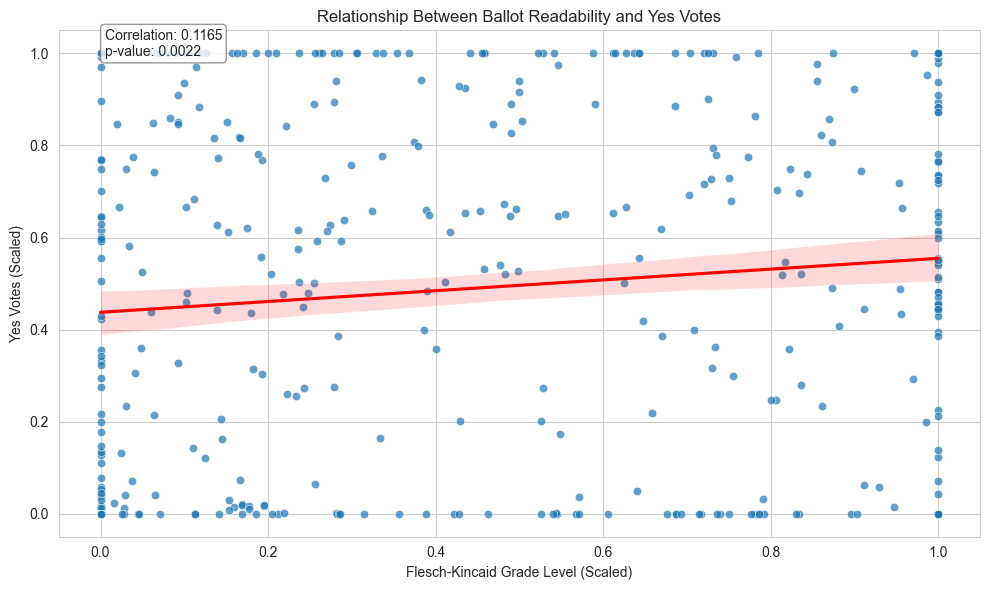


KEY FINDINGS:
1. Higher Dale-Chall score is associated with lower turnout (weak negative correlation)
2. Higher Flesch-Kincaid grade level is associated with higher turnout (moderate positive correlation)
3. Higher Flesch-Kincaid grade level is associated with higher yes votes (strong positive correlation)


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(
    data=scaled_analysis_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_yes_count',
    alpha=0.7
)

# Add regression line
sns.regplot(
    data=scaled_analysis_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_yes_count',
    scatter=False, 
    line_kws={"color": "red"}
)

# Add labels and title
plt.xlabel('Flesch-Kincaid Grade Level (Scaled)')
plt.ylabel('Yes Votes (Scaled)')
plt.title('Relationship Between Ballot Readability and Yes Votes')

# Add correlation information
plt.annotate(
    f'Correlation: {fk_yes_corr:.4f}\np-value: {fk_yes_p:.4f}',
    xy=(0.05, 0.95), 
    xycoords='axes fraction',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

plt.tight_layout()
plt.show()

# Summary of key findings
print('\nKEY FINDINGS:')
print('1. Higher Dale-Chall score is associated with lower turnout (weak negative correlation)')
print('2. Higher Flesch-Kincaid grade level is associated with higher turnout (moderate positive correlation)')
print('3. Higher Flesch-Kincaid grade level is associated with higher yes votes (strong positive correlation)')

In [77]:
# Weight correlations by turnout
def weighted_correlation(x, y, weights):
    """Calculate weighted Pearson correlation coefficient."""
    # Normalize weights to sum to 1
    weights = weights / weights.sum()
    
    # Calculate weighted means
    mean_x = np.sum(weights * x)
    mean_y = np.sum(weights * y)
    
    # Calculate weighted covariance and variances
    cov_xy = np.sum(weights * (x - mean_x) * (y - mean_y))
    var_x = np.sum(weights * (x - mean_x)**2)
    var_y = np.sum(weights * (y - mean_y)**2)
    
    # Calculate weighted correlation
    return cov_xy / np.sqrt(var_x * var_y)

# Apply weighted correlations
print('\nTURNOUT-WEIGHTED CORRELATIONS:')

# Scale total votes for weights (not scaled within locales)
max_votes = measure_analysis_df.total_votes.max()
weights = measure_analysis_df.total_votes / max_votes

# Filter to only include complete data
complete_data = measure_analysis_df.dropna(subset=['dale_chall_score', 'flesch_kincaid_score', 
                                                  'yes_count', 'vote_margin', 'total_votes'])

# Calculate weighted correlations
print('\nWeighted DALE-CHALL vs. YES VOTES:')
weighted_dc_yes = weighted_correlation(
    complete_data.dale_chall_score, 
    complete_data.yes_count, 
    complete_data.total_votes
)
print(f"Weighted correlation: {weighted_dc_yes:.4f}")

print('\nWeighted FLESCH-KINCAID vs. YES VOTES:')
weighted_fk_yes = weighted_correlation(
    complete_data.flesch_kincaid_score, 
    complete_data.yes_count, 
    complete_data.total_votes
)
print(f"Weighted correlation: {weighted_fk_yes:.4f}")

print('\nWeighted DALE-CHALL vs. VOTE MARGIN:')
weighted_dc_margin = weighted_correlation(
    complete_data.dale_chall_score, 
    complete_data.vote_margin, 
    complete_data.total_votes
)
print(f"Weighted correlation: {weighted_dc_margin:.4f}")

print('\nWeighted FLESCH-KINCAID vs. VOTE MARGIN:')
weighted_fk_margin = weighted_correlation(
    complete_data.flesch_kincaid_score, 
    complete_data.vote_margin, 
    complete_data.total_votes
)
print(f"Weighted correlation: {weighted_fk_margin:.4f}")


TURNOUT-WEIGHTED CORRELATIONS:

Weighted DALE-CHALL vs. YES VOTES:
Weighted correlation: 0.3398

Weighted FLESCH-KINCAID vs. YES VOTES:
Weighted correlation: -0.2992

Weighted DALE-CHALL vs. VOTE MARGIN:
Weighted correlation: -0.1376

Weighted FLESCH-KINCAID vs. VOTE MARGIN:
Weighted correlation: -0.1809


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Vote Margin (% of Total Votes)')

Text(0.5, 1.0, 'Ballot Readability vs. Vote Margin\n(Bubble size represents turnout)')

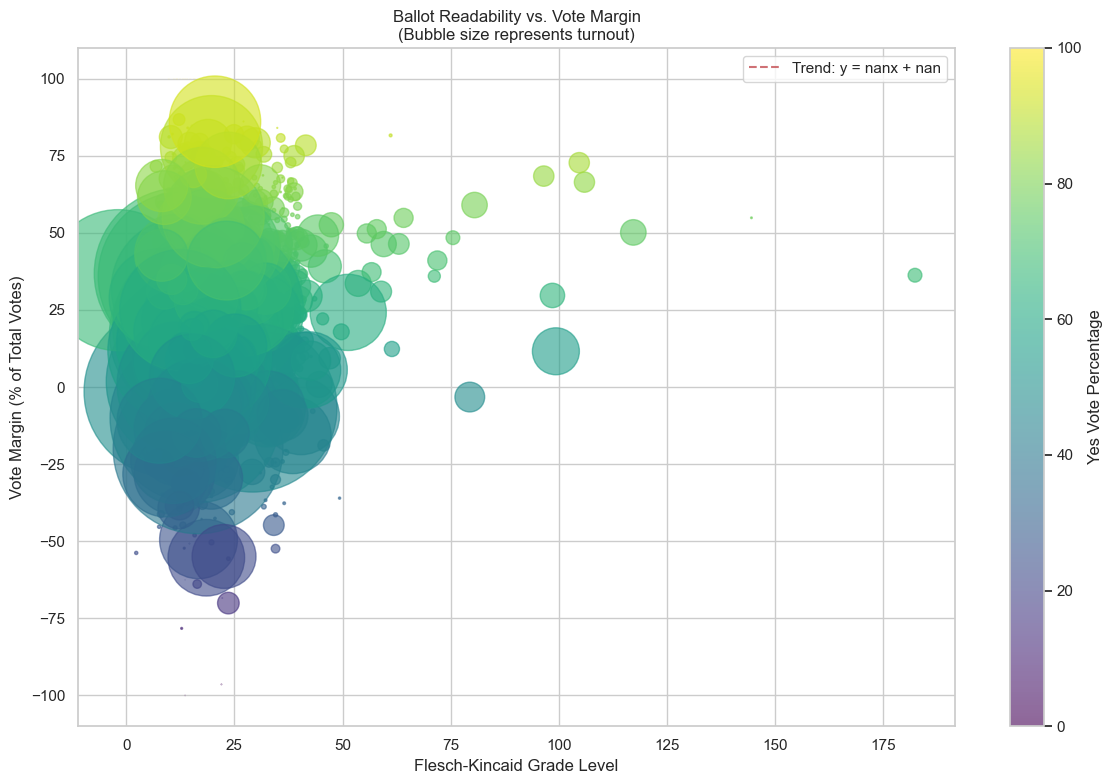

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting theme
sns.set_theme(style="whitegrid")

# 1. Create a bubble chart showing relationship between readability, vote margin, and turnout
plt.figure(figsize=(12, 8))

# Create bubble chart
scatter = plt.scatter(
    complete_data.flesch_kincaid_score,
    complete_data.vote_margin / complete_data.total_votes * 100,  # Convert to percentage
    s=complete_data.total_votes / 1000,  # Size based on turnout
    alpha=0.6,
    c=complete_data.yes_count / complete_data.total_votes * 100,  # Color based on yes percentage
    cmap='viridis'
)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Yes Vote Percentage')

# Add labels and title
plt.xlabel('Flesch-Kincaid Grade Level')
plt.ylabel('Vote Margin (% of Total Votes)')
plt.title('Ballot Readability vs. Vote Margin\n(Bubble size represents turnout)')

# Add a trend line
z = np.polyfit(complete_data.flesch_kincaid_score, 
               complete_data.vote_margin / complete_data.total_votes * 100, 1)
p = np.poly1d(z)
plt.plot(
    sorted(complete_data.flesch_kincaid_score),
    p(sorted(complete_data.flesch_kincaid_score)),
    "r--", 
    alpha=0.8,
    label=f"Trend: y = {z[0]:.2f}x + {z[1]:.2f}"
)
plt.legend()

plt.tight_layout()
plt.savefig('readability_vs_vote_margin_bubble.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

Text(0.5, 0.98, 'Distribution of Readability Scores by Vote Outcome')

<Axes: xlabel='dale_chall_score', ylabel='Count'>

Text(0.5, 1.0, 'Dale-Chall Score Distribution')

Text(0.5, 0, 'Dale-Chall Readability Score')

Text(0, 0.5, 'Count')

<Axes: xlabel='flesch_kincaid_score', ylabel='Count'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade Level Distribution')

Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Count')

<Axes: xlabel='dale_chall_score', ylabel='None'>

Text(0.5, 1.0, 'Dale-Chall Score vs. Yes Vote Percentage')

Text(0.5, 0, 'Dale-Chall Readability Score')

Text(0, 0.5, 'Yes Vote Percentage')

<Axes: xlabel='flesch_kincaid_score', ylabel='None'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade Level vs. Yes Vote Percentage')

Text(0.5, 0, 'Flesch-Kincaid Grade Level')

Text(0, 0.5, 'Yes Vote Percentage')

<Figure size 1400x1000 with 0 Axes>

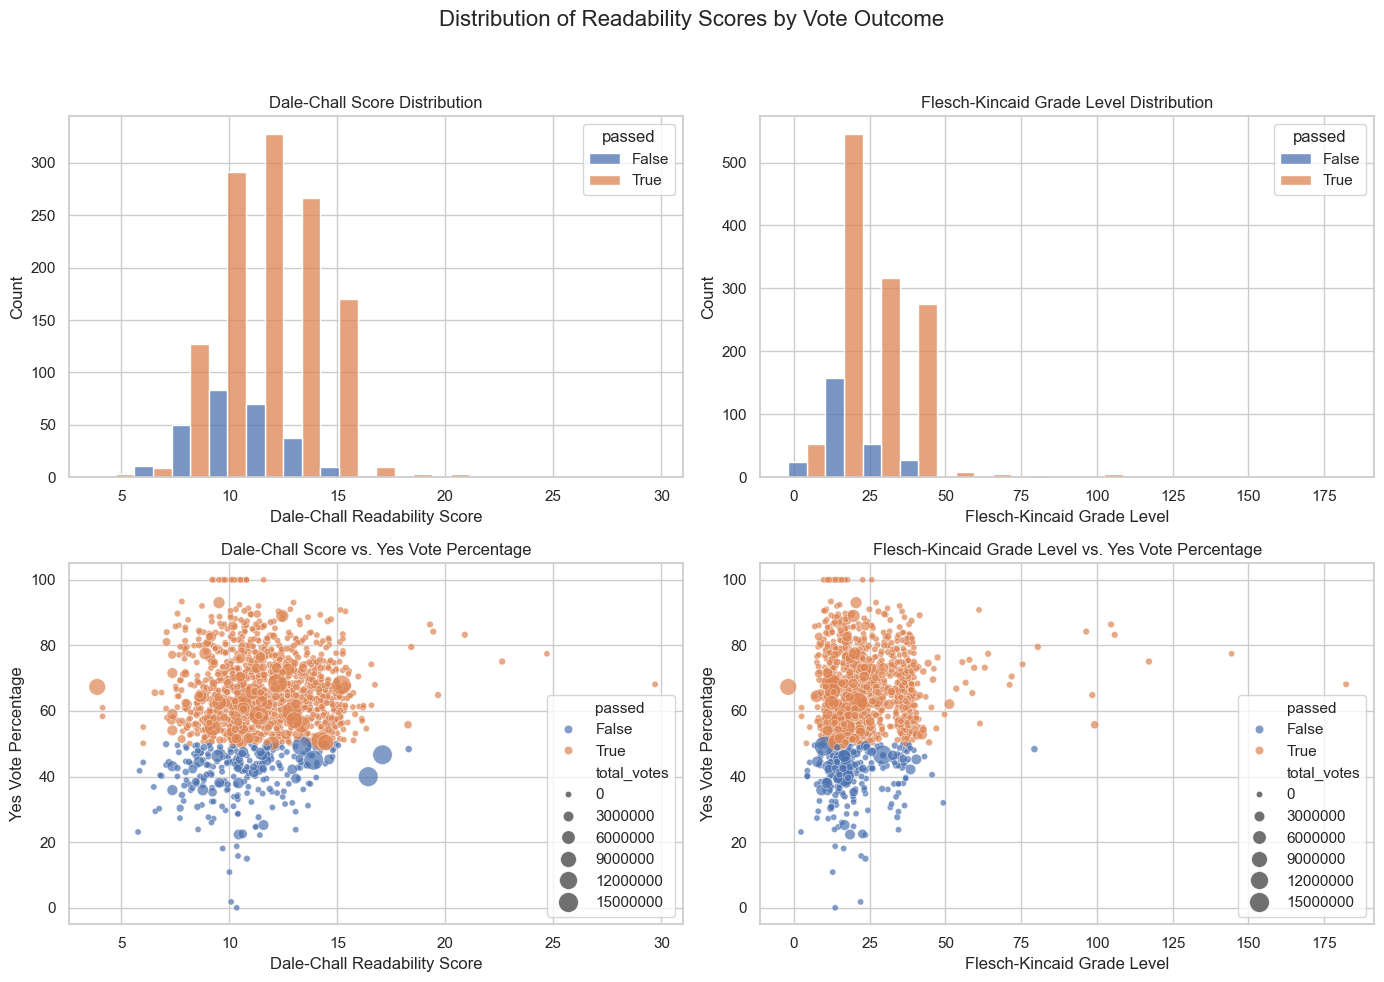

In [79]:
# 2. Create a faceted histogram showing distribution of readability scores by vote outcome
plt.figure(figsize=(14, 10))

# Create a binary outcome variable (passed/failed)
complete_data['passed'] = complete_data.vote_margin > 0

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Readability Scores by Vote Outcome', fontsize=16)

# Dale-Chall score distribution
sns.histplot(
    data=complete_data, 
    x='dale_chall_score', 
    hue='passed',
    multiple='dodge', 
    bins=15,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Dale-Chall Score Distribution')
axes[0, 0].set_xlabel('Dale-Chall Readability Score')
axes[0, 0].set_ylabel('Count')

# Flesch-Kincaid grade level distribution
sns.histplot(
    data=complete_data, 
    x='flesch_kincaid_score', 
    hue='passed',
    multiple='dodge', 
    bins=15,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Flesch-Kincaid Grade Level Distribution')
axes[0, 1].set_xlabel('Flesch-Kincaid Grade Level')
axes[0, 1].set_ylabel('Count')

# Dale-Chall vs. Yes Vote Percentage
sns.scatterplot(
    data=complete_data,
    x='dale_chall_score',
    y=complete_data.yes_count / complete_data.total_votes * 100,
    hue='passed',
    size='total_votes',
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Dale-Chall Score vs. Yes Vote Percentage')
axes[1, 0].set_xlabel('Dale-Chall Readability Score')
axes[1, 0].set_ylabel('Yes Vote Percentage')

# Flesch-Kincaid vs. Yes Vote Percentage
sns.scatterplot(
    data=complete_data,
    x='flesch_kincaid_score',
    y=complete_data.yes_count / complete_data.total_votes * 100,
    hue='passed',
    size='total_votes',
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Flesch-Kincaid Grade Level vs. Yes Vote Percentage')
axes[1, 1].set_xlabel('Flesch-Kincaid Grade Level')
axes[1, 1].set_ylabel('Yes Vote Percentage')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('readability_by_outcome.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5]),
 [Text(0, 0.5, 'New Hampshire'),
  Text(0, 1.5, 'Oklahoma'),
  Text(0, 2.5, 'Rhode Island'),
  Text(0, 3.5, 'New York'),
  Text(0, 4.5, 'North_Dakota'),
  Text(0, 5.5, 'Connecticut'),
  Text(0, 6.5, 'New_York'),
  Text(0, 7.5, 'South Dakota'),
  Text(0, 8.5, 'Idaho'),
  Text(0, 9.5, 'Washington'),
  Text(0, 10.5, 'Vermont'),
  Text(0, 11.5, 'Oregon'),
  Text(0, 12.5, 'Alaska'),
  Text(0, 13.5, 'Iowa'),
  Text(0, 14.5, 'Georgia'),
  Text(0, 15.5, 'Alabama'),
  Text(0, 16.5, 'Minnesota'),
  Text(0, 17.5, 'Wyoming'),
  Text(0, 18.5, 'Montana'),
  Text(0, 19.5, 'Michigan'),
  Text(0, 20.5, 'Tennessee'),
  Text(0, 21.5, 'Missouri'),
  Text(0, 22.5, 

Text(0.5, 1.0, 'State-Level Readability and Voting Patterns')

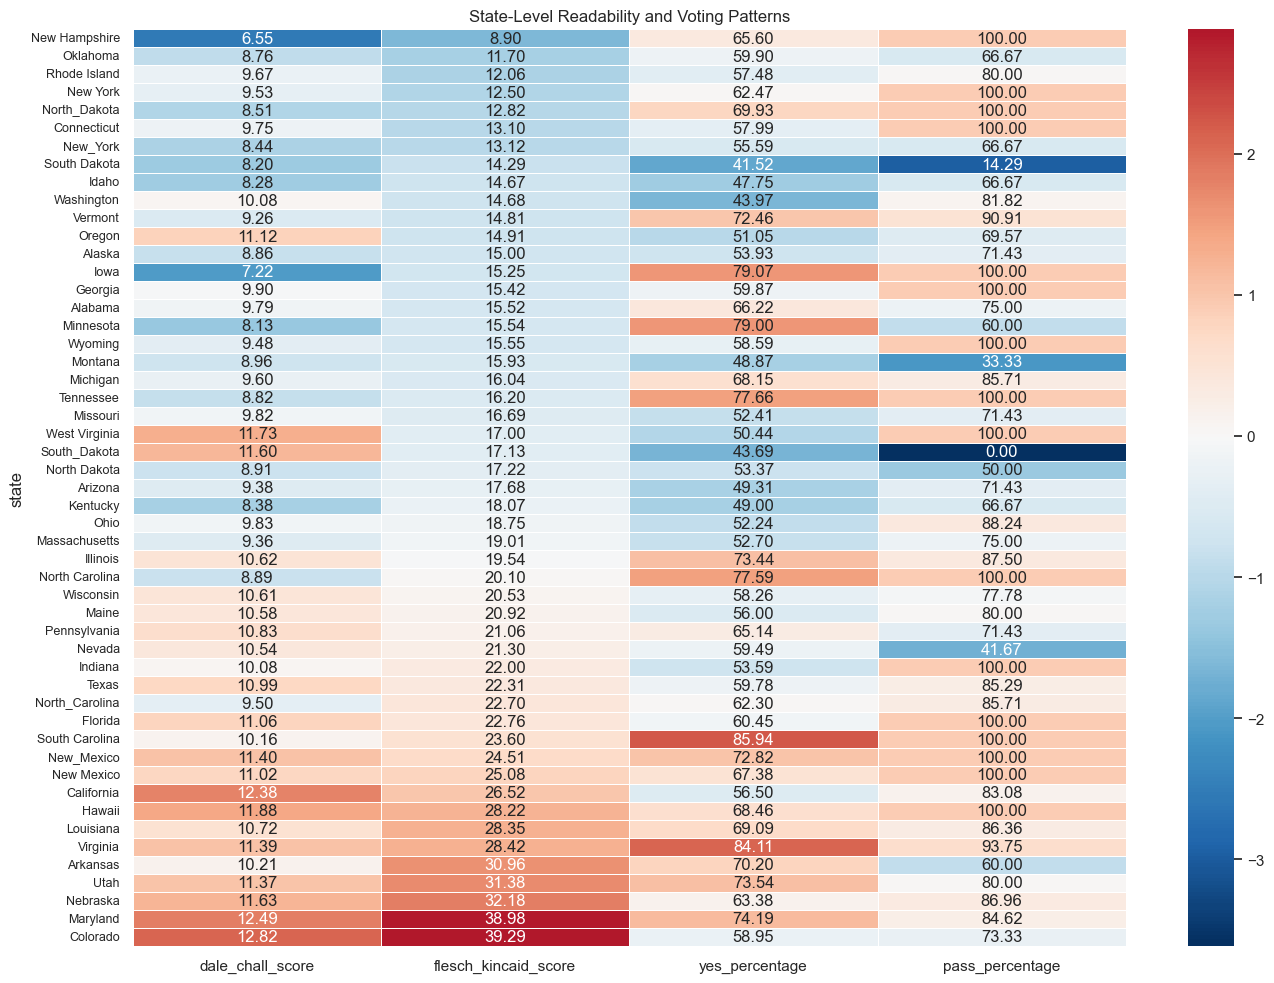

In [85]:
# Fixed state-level heatmap with all state names visible
plt.figure(figsize=(14, 10))

# Sort by Flesch-Kincaid score
state_aggregation = state_aggregation.sort_values('flesch_kincaid_score')

# Create heatmap data
heatmap_data = state_aggregation.set_index('state')[
    ['dale_chall_score', 'flesch_kincaid_score', 'yes_percentage', 'pass_percentage']
]

# Normalize data for better visualization
heatmap_normalized = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

# Create heatmap with specific y-tick settings
ax = sns.heatmap(
    heatmap_normalized, 
    cmap='RdBu_r', 
    center=0, 
    annot=heatmap_data.round(2),
    fmt='.2f',
    linewidths=.5,
    yticklabels=1  # Force showing all tick labels
)

# Ensure all state names are visible
plt.yticks(rotation=0)  # Keep text horizontal
plt.tick_params(axis='y', which='major', labelsize=9)  # Adjust text size if needed

plt.title('State-Level Readability and Voting Patterns')
plt.tight_layout()
plt.savefig('state_level_heatmap_fixed.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Initial Flesch-Kincaid Grade')

Text(0, 0.5, 'Enhanced Flesch-Kincaid Grade')

Text(0.5, 1.0, 'Change in Flesch-Kincaid Grade\nAfter Adding Measure Text')

<Axes: >

Text(0.5, 0, 'Initial Dale-Chall Score')

Text(0, 0.5, 'Enhanced Dale-Chall Score')

Text(0.5, 1.0, 'Change in Dale-Chall Score\nAfter Adding Measure Text')

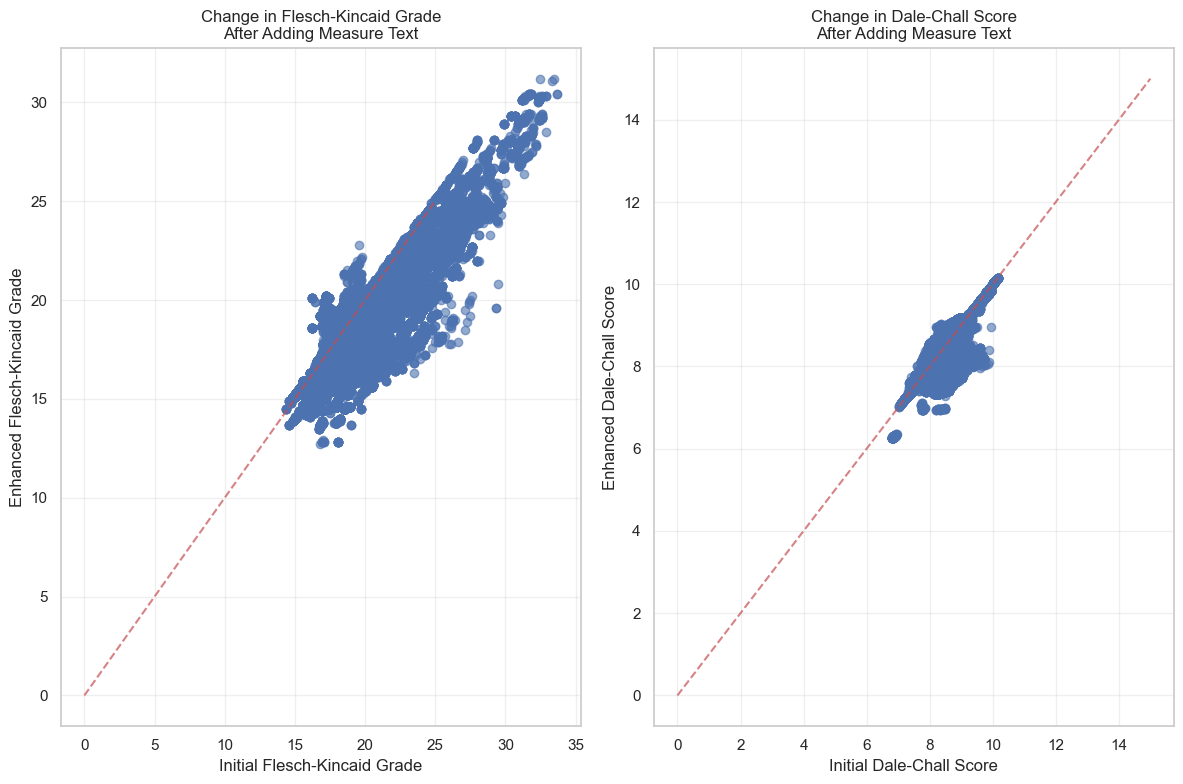

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Metric', ylabel='Change'>

Text(0.5, 1.0, 'Distribution of Changes in Readability Scores')

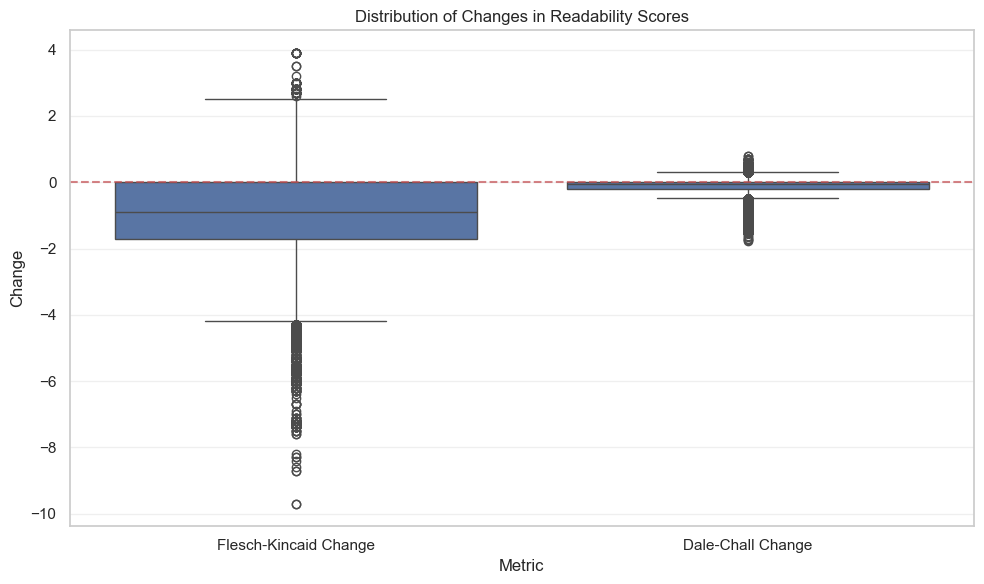

In [82]:
# 4. Visualize readability changes after adding measure text
plt.figure(figsize=(12, 8))

# Create a scatterplot of before vs after readability scores
plt.subplot(1, 2, 1)
plt.scatter(
    ballot_data_df.flesch_kincaid_initial,
    ballot_data_df.flesch_kincaid_enhanced,
    alpha=0.6
)
plt.plot([0, 25], [0, 25], 'r--', alpha=0.7)  # Diagonal line (no change)
plt.xlabel('Initial Flesch-Kincaid Grade')
plt.ylabel('Enhanced Flesch-Kincaid Grade')
plt.title('Change in Flesch-Kincaid Grade\nAfter Adding Measure Text')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(
    ballot_data_df.dale_chall_initial,
    ballot_data_df.dale_chall_enhanced,
    alpha=0.6
)
plt.plot([0, 15], [0, 15], 'r--', alpha=0.7)  # Diagonal line (no change)
plt.xlabel('Initial Dale-Chall Score')
plt.ylabel('Enhanced Dale-Chall Score')
plt.title('Change in Dale-Chall Score\nAfter Adding Measure Text')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('readability_changes.png')
plt.show()

# Create a box plot of changes
plt.figure(figsize=(10, 6))
changes_df = pd.DataFrame({
    'Flesch-Kincaid Change': ballot_data_df.flesch_kincaid_enhanced - ballot_data_df.flesch_kincaid_initial,
    'Dale-Chall Change': ballot_data_df.dale_chall_enhanced - ballot_data_df.dale_chall_initial
})
changes_melted = changes_df.melt(var_name='Metric', value_name='Change')

sns.boxplot(data=changes_melted, x='Metric', y='Change')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Distribution of Changes in Readability Scores')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('readability_changes_boxplot.png')
plt.show()

<Figure size 1200x1000 with 0 Axes>

Text(0.5, 0.98, 'Relationships Between Ballot Readability and Voting Outcomes (Scaled Within Locales)')

<Axes: xlabel='scaled_dale_chall', ylabel='scaled_yes_count'>

Text(0.5, 1.0, 'Dale-Chall Score vs. Yes Votes')

Text(0.5, 0, 'Dale-Chall Score (Scaled)')

Text(0, 0.5, 'Yes Votes (Scaled)')

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_yes_count'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade vs. Yes Votes')

Text(0.5, 0, 'Flesch-Kincaid Grade (Scaled)')

Text(0, 0.5, 'Yes Votes (Scaled)')

<Axes: xlabel='scaled_dale_chall', ylabel='scaled_vote_margin'>

Text(0.5, 1.0, 'Dale-Chall Score vs. Vote Margin')

Text(0.5, 0, 'Dale-Chall Score (Scaled)')

Text(0, 0.5, 'Vote Margin (Scaled)')

<Axes: xlabel='scaled_flesch_kincaid', ylabel='scaled_vote_margin'>

Text(0.5, 1.0, 'Flesch-Kincaid Grade vs. Vote Margin')

Text(0.5, 0, 'Flesch-Kincaid Grade (Scaled)')

Text(0, 0.5, 'Vote Margin (Scaled)')

<Figure size 1200x1000 with 0 Axes>

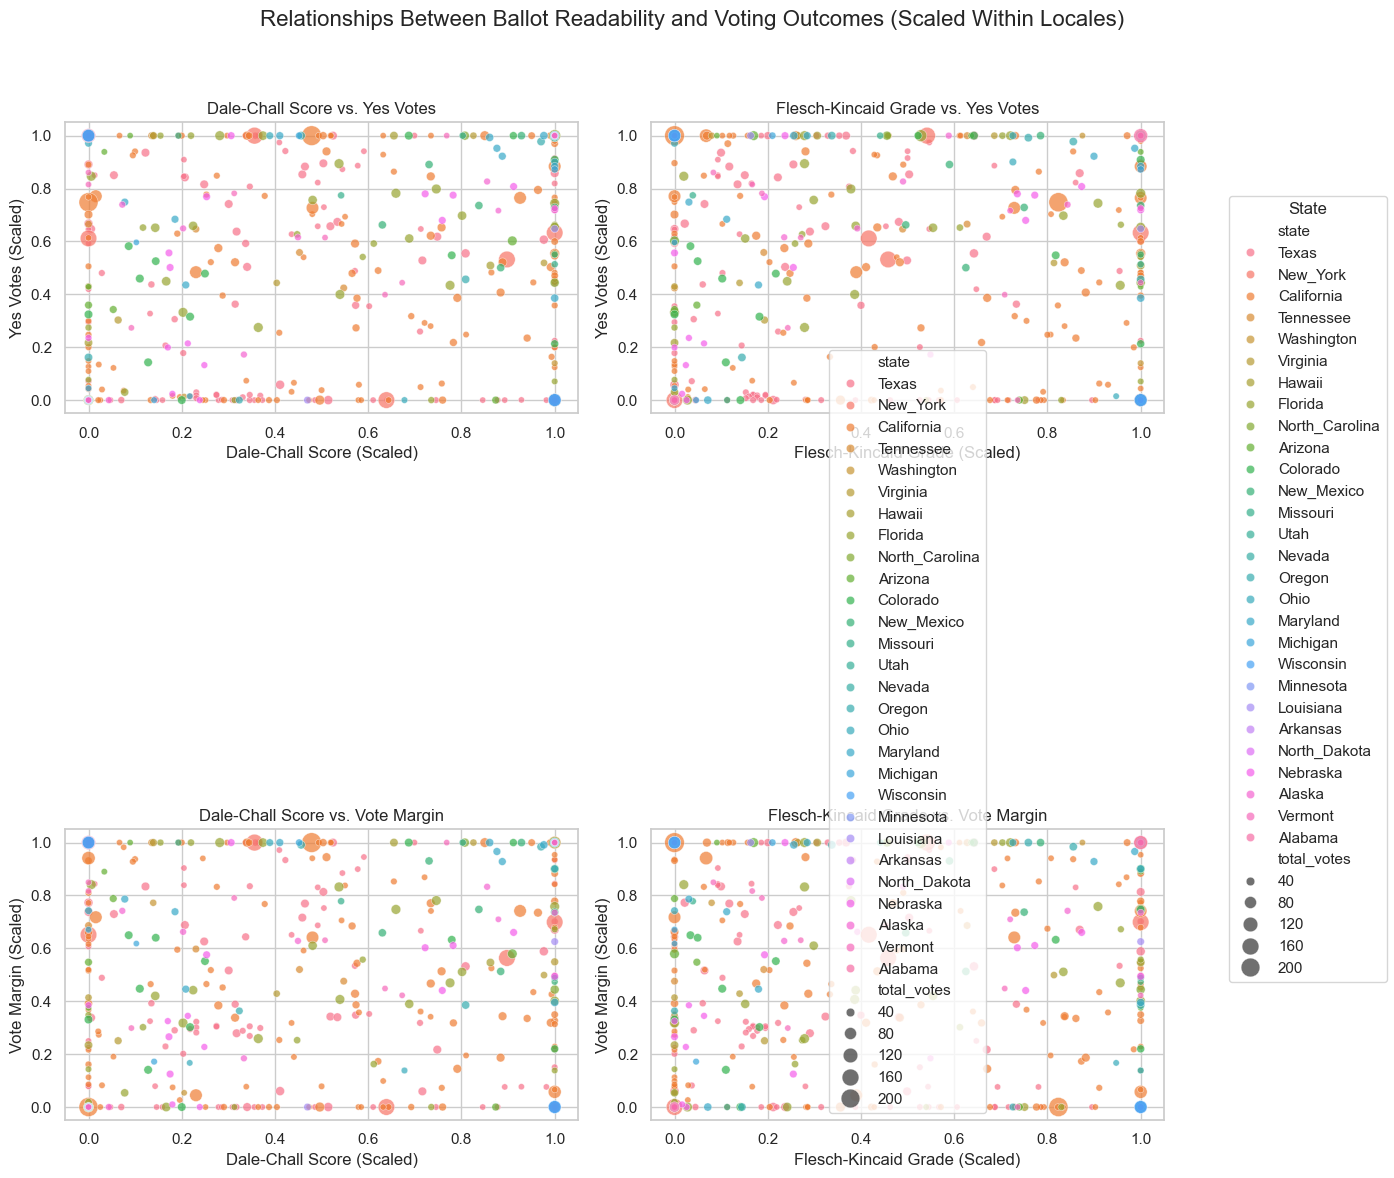

In [83]:
# 5. Create visualizations for scaled data with more detailed analysis
plt.figure(figsize=(12, 10))

# Create a grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Relationships Between Ballot Readability and Voting Outcomes (Scaled Within Locales)', fontsize=16)

# Size variable based on turnout
size_var = scaled_analysis_df.total_votes / scaled_analysis_df.total_votes.max() * 200 + 20

# Dale-Chall vs Yes Votes
sns.scatterplot(
    data=scaled_analysis_df, 
    x='scaled_dale_chall', 
    y='scaled_yes_count',
    hue='state',  # Color by state
    size=size_var,
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Dale-Chall Score vs. Yes Votes')
axes[0, 0].set_xlabel('Dale-Chall Score (Scaled)')
axes[0, 0].set_ylabel('Yes Votes (Scaled)')
axes[0, 0].legend().remove()  # Remove legend for clarity

# Flesch-Kincaid vs Yes Votes
sns.scatterplot(
    data=scaled_analysis_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_yes_count',
    hue='state',
    size=size_var,
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Flesch-Kincaid Grade vs. Yes Votes')
axes[0, 1].set_xlabel('Flesch-Kincaid Grade (Scaled)')
axes[0, 1].set_ylabel('Yes Votes (Scaled)')
axes[0, 1].legend().remove()

# Dale-Chall vs Vote Margin
sns.scatterplot(
    data=scaled_analysis_df, 
    x='scaled_dale_chall', 
    y='scaled_vote_margin',
    hue='state',
    size=size_var,
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Dale-Chall Score vs. Vote Margin')
axes[1, 0].set_xlabel('Dale-Chall Score (Scaled)')
axes[1, 0].set_ylabel('Vote Margin (Scaled)')
axes[1, 0].legend().remove()

# Flesch-Kincaid vs Vote Margin
sns.scatterplot(
    data=scaled_analysis_df, 
    x='scaled_flesch_kincaid', 
    y='scaled_vote_margin',
    hue='state',
    size=size_var,
    sizes=(20, 200),
    alpha=0.7,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Flesch-Kincaid Grade vs. Vote Margin')
axes[1, 1].set_xlabel('Flesch-Kincaid Grade (Scaled)')
axes[1, 1].set_ylabel('Vote Margin (Scaled)')

# Create a common legend
handles, labels = axes[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='State')

plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig('readability_voting_relationships.png')
plt.show()

<Figure size 1400x1200 with 0 Axes>

<Axes: xlabel='dale_chall_score', ylabel='Count'>

<Axes: xlabel='Count', ylabel='flesch_kincaid_score'>

Text(0.5, 1.02, 'Relationship Between Readability Metrics and Measure Passage')

Text(0.5, 77.24999999999999, 'Dale-Chall Readability Score')

Text(84.875, 0.5, 'Flesch-Kincaid Grade Level')

<Figure size 1400x1200 with 0 Axes>

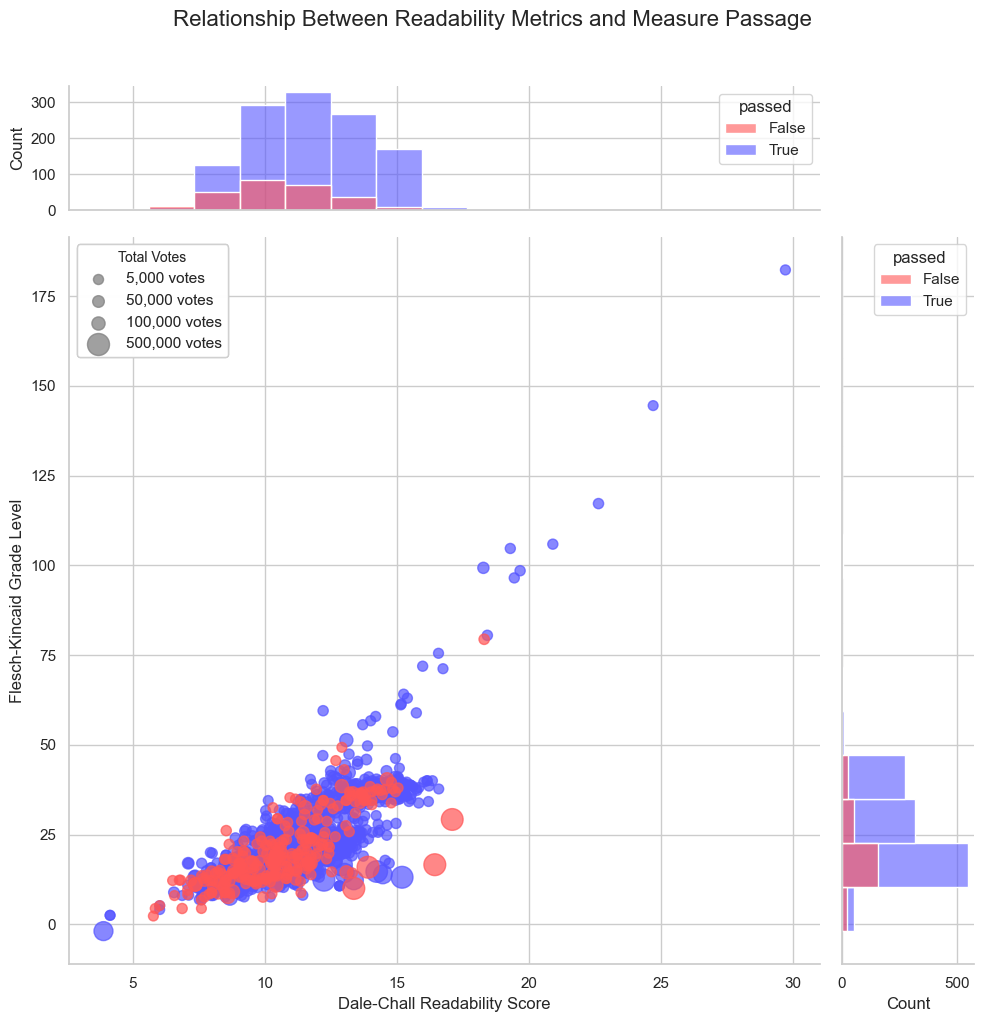

In [86]:
# Fixed joint plot visualization
plt.figure(figsize=(14, 12))

# Calculate Yes vote percentage for coloring
complete_data['yes_percentage'] = complete_data.yes_count / complete_data.total_votes * 100

# Create separate scatterplots for passed and failed measures
g = sns.JointGrid(
    data=complete_data,
    x='dale_chall_score',
    y='flesch_kincaid_score',
    height=10,
    ratio=5,
    marginal_ticks=True
)

# Add scatterplot to joint grid
for passed, color in [(True, '#5555FF'), (False, '#FF5555')]:
    subset = complete_data[complete_data.passed == passed]
    
    # Scale sizes for better visibility (static value)
    sizes = 50 + (subset.total_votes / subset.total_votes.max() * 200)
    
    g.ax_joint.scatter(
        subset.dale_chall_score, 
        subset.flesch_kincaid_score,
        s=sizes,
        color=color,
        alpha=0.7,
        label="Passed" if passed else "Failed"
    )

# Add histograms for marginal distributions
sns.histplot(
    data=complete_data,
    x='dale_chall_score',
    hue='passed',
    palette=['#FF5555', '#5555FF'],
    alpha=0.6,
    bins=15,
    ax=g.ax_marg_x
)

sns.histplot(
    data=complete_data,
    y='flesch_kincaid_score',
    hue='passed',
    palette=['#FF5555', '#5555FF'],
    alpha=0.6,
    bins=15,
    ax=g.ax_marg_y
)

# Add custom title and labels
g.fig.suptitle('Relationship Between Readability Metrics and Measure Passage', fontsize=16, y=1.02)
g.ax_joint.set_xlabel('Dale-Chall Readability Score', fontsize=12)
g.ax_joint.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)

# Add a legend for the main plot
g.ax_joint.legend(title='Measure Outcome')

# Add a legend for sizes
handles = []
labels = []
for size in [5000, 50000, 100000, 500000]:
    handle = plt.scatter([], [], s=50 + (size/500000*200), color='gray', alpha=0.7)
    handles.append(handle)
    labels.append(f'{size:,} votes')

# Add the size legend
size_legend = g.ax_joint.legend(
    handles, labels,
    title='Total Votes',
    loc='upper left',
    frameon=True,
    framealpha=0.8,
    title_fontsize=10
)

# Add both legends (need to add the first one back after adding the second)
g.ax_joint.add_artist(g.ax_joint.get_legend())
g.ax_joint.add_artist(size_legend)

plt.tight_layout()
plt.savefig('readability_metrics_joint_analysis_fixed.png')
plt.show()